<a href="https://colab.research.google.com/github/andrecsq/trabalho_simulacao/blob/main/Trabalho_AD_Simulacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Como fazer da forma errada

In [ ]:
beta = 0.5
gamma = 0.3
time_steps = 200

total_population = 1000
initial_infected = 10 

infected = np.zeros(time_steps) 
infected[0] = initial_infected  

In [ ]:
# Recuperação é 1/taxa

for t in range(1, time_steps):    
    susceptible = total_population-infected[t-1]
    
    cured = np.random.binomial(n=infected[t-1], p=gamma)
    new_infected = np.random.binomial(n=susceptible, p=beta)
    
    infected[t] = infected[t-1] - cured + new_infected

susceptible = 1000 - infected

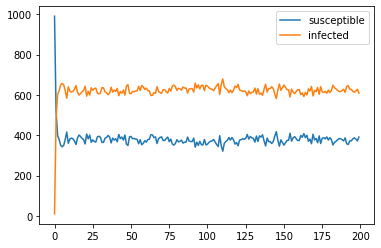

In [ ]:
plt.plot(susceptible, label='susceptible')
plt.plot(infected, label='infected')
plt.legend()

# Solução Analítica

In [231]:
beta = 2
gamma = 0.5
total_population = 100
time_steps = 50
initial_infected = 1

I_inf = (1- gamma/beta)*total_population
V = I_inf/initial_infected - 1
x = beta - gamma

def I(t):
  return I_inf / (1 + V*np.exp(-x*t) )

infected_analytic = np.array([I(t) for t in range(0, time_steps)])
susceptible_analytic = total_population - infected_analytic

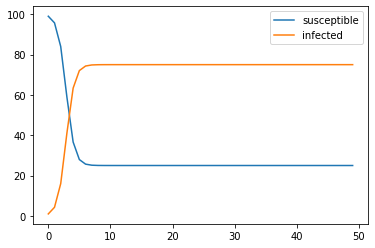

In [232]:
plt.plot(susceptible_analytic, label='susceptible')
plt.plot(infected_analytic, label='infected')
plt.legend()

## Implementação Eventos

In [ ]:
import queue
from dataclasses import dataclass, field

@dataclass(order=True)
class Event:
  time: float
  event_type: str=field(compare=False)
  x: int=field(compare=False)
  y: int=field(compare=False, default=None)

In [ ]:
def initialize_population_state(total_population, initial_infected):
  pop_state = [False] * total_population
  for i in range(initial_infected):
    pop_state[i] = True
  return pop_state

def initialize_queue(beta, total_population, initial_infected):
  q = queue.PriorityQueue()
  for i in range(total_population):
    for j in range(total_population):
      if i != j:
        infection_time = np.random.exponential(beta)
        infection_event = Event(infection_time, 'infection', i, j)
        q.put(infection_event)
  
  for i in range(initial_infected):
    cure_time = np.random.exponential(gamma)
    cure_event = Event(cure_time, 'cure', i)
    q.put(cure_event)

  return q

In [ ]:
# is_infected = initialize_population_state(total_population, initial_infected)
# q = initialize_queue(gamma, total_population)

In [ ]:
def apply_infection(gamma, e, is_infected, q):
  time = e.time
  infector = e.x
  infected = e.y

  is_infected[infected] = True # Now infected

  cure_time = np.random.exponential(gamma) # Creates random cure time
  cure_event_infected = Event(e.time + cure_time, 'cure', infected) # Create Event objects
  q.put(cure_event_infected) # Add events to queue

  if DEBUG:
    print(f"t:{round(time, 6)} - {infector}->{infected}")

  events.append(Event(time, 'infection', infected, infector))

def generate_new_infection(beta, e, q):
  infection_time = e.time + np.random.exponential(beta)
  infection_event_x_y = Event(infection_time, 'infection', e.x, e.y) 
  q.put(infection_event_x_y)

def handle_cure(e, is_infected):
  is_infected[e.x] = False 
  if DEBUG:
      print(f"t:{round(e.time, 6)} - {e.x} is cured")
  events.append(Event(e.time, 'cure', e.x))

# def handle_infection(beta, gamma, e, is_infected, q, null_infections):    
#   if is_infected[e.x] and not is_infected[e.y]:
#     apply_infection(gamma, e, is_infected, q) 
#     if DEBUG:
#       print(f"{null_infections} events without infection")
#     null_infections = -1
#   generate_new_infection(beta, e, q)
#   return null_infections + 1

In [ ]:
events = []

def print_state_string(infected_array):
  is_infected_formatted = "".join([str(int(i)) for i in infected_array])
  print(is_infected_formatted)

def simulate_epidemic(beta, gamma, total_population, initial_infected, max_time):
  is_infected = initialize_population_state(total_population, initial_infected)
  if DEBUG:
    print_state_string(is_infected)
  q = initialize_queue(beta, total_population, initial_infected)
  times = []
  amount_infected = []


  null_infections = 0
  while not q.empty():
    e = q.get()
    
    if e.time > max_time:
      return times, amount_infected
    if e.event_type == 'cure':
      handle_cure(e, is_infected)     
      if DEBUG:
        print_state_string(is_infected)
    elif e.event_type == 'infection' and is_infected[e.x] and not is_infected[e.y]:   
      if DEBUG:
        print(f"{null_infections} events without infection")
      null_infections = 0
      apply_infection(gamma, e, is_infected, q)    
      generate_new_infection(beta, e, q) 
      if DEBUG:
        print_state_string(is_infected)
    elif e.event_type == 'infection' and not is_infected[e.x] or is_infected[e.y]:
      null_infections += 1
      generate_new_infection(beta, e, q) 

    # if DEBUG:
    #   print(q.qsize())

    times.append(e.time)
    amount_infected.append(sum(is_infected))

In [250]:
beta = 1/2 # beta = 2
gamma = 0.5

total_population = 100
initial_infected = 1
DEBUG = False

times, amount_infected = simulate_epidemic(beta, 
                                          gamma, 
                                          total_population,
                                          initial_infected,
                                          0.5)

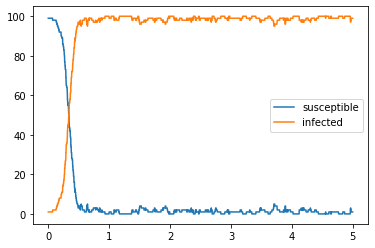

In [251]:
amount_susceptible = total_population - np.array(amount_infected)
new_times = np.array(times) * 10
plt.plot(new_times, amount_susceptible, label='susceptible')
plt.plot(new_times, amount_infected, label='infected')
plt.legend()

In [252]:
# for i in range(len(times)):
#   print(f"{times[i]}:{amount_infected[i]}")